In [10]:
import matplotlib.pyplot as plt  # plots
import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulations
import seaborn as sns  # more plots
import sklearn
sns.set()

import warnings  
from itertools import product  # some useful functions

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf  # statistics and econometrics
import statsmodels.tsa.api as smt
from dateutil.relativedelta import \
    relativedelta  # working with dates with style
from scipy.optimize import minimize  # for function minimization
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore") # `do not disturbe` mode

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
df_catch = pd.read_csv('/home/savin/Documents/DEV/dataset_fish/Датасет/with_same_ship_ids_between_db/db1/catch.csv')

In [4]:
df_catch.head()

,id_ves,date,id_region,id_fish,catch_volume,id_regime,permit,id_own
0,1628,2022-01-01,272,400,31.874,41,2824,961
1,70,2022-01-01,277,886,0.476,1,2414,1281
2,1608,2022-01-01,116,409,26.310,15,3031,1227
3,832,2022-01-01,272,292,9.541,1,1894,1281
4,832,2022-01-01,272,113,0.062,1,1894,1281


In [6]:
id_own = pd.Series(df_catch['id_own']).unique()
rate_own = pd.DataFrame()
for el in id_own:
    aggr_df = df_catch.loc[df_catch['id_own']==el].groupby("date")[["catch_volume"]].sum()
    aggr_df.columns = [f"{el}"]
    rate_own = pd.concat([rate_own, aggr_df], axis=1)
rate_own.head()

,961,1281,1227,1011,1219,942,984,951,1164,1091,...,1044,1259,996,1280,1045,1399,1129,1004,954,1101
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,31.874,77.870,26.31,230.705,336.914,59.087,12.196,94.889,61.787,79.956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02,169.866,93.250,NaN,593.726,NaN,105.141,NaN,268.387,47.167,224.484,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-03,577.346,89.951,34.56,628.579,NaN,142.241,NaN,245.295,120.646,162.778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,663.930,75.758,NaN,259.477,NaN,86.626,NaN,147.306,328.844,204.438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-05,345.875,47.301,NaN,482.655,NaN,136.666,NaN,177.678,152.780,86.839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df = rate_own['961'].dropna()

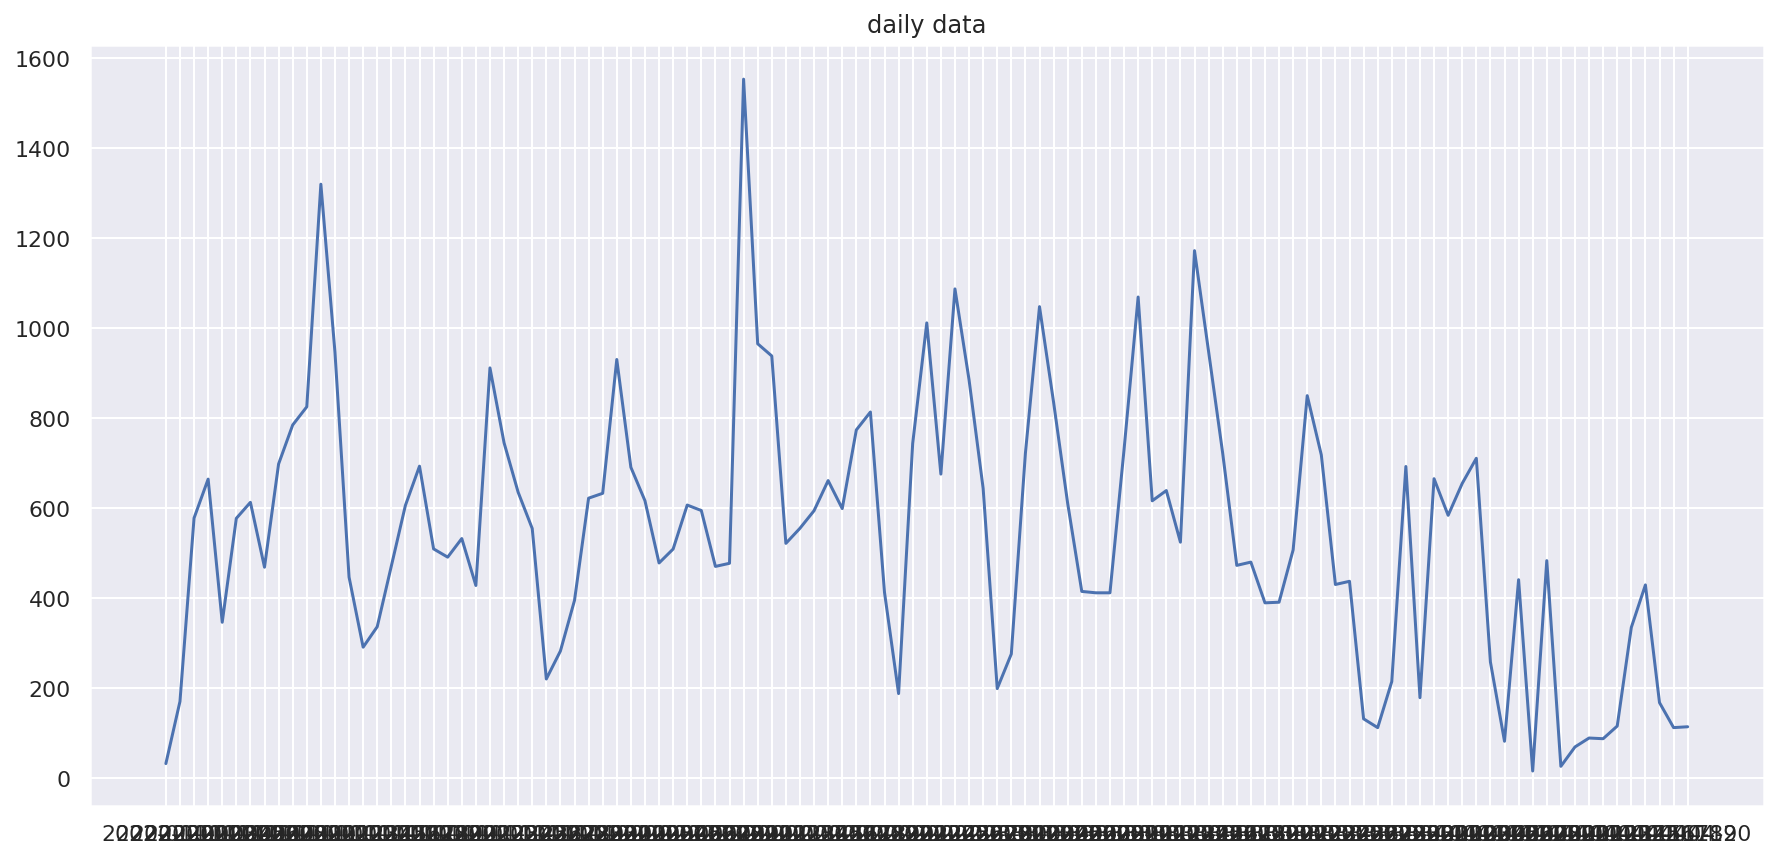

In [26]:
plt.figure(figsize=(15, 7))
plt.plot(df)
plt.title("daily data")
plt.grid(True)
plt.show()

In [13]:
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])


moving_average(df, 24)  # prediction for the last observed day (past 24 hours)

281.70079166666665

In [63]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

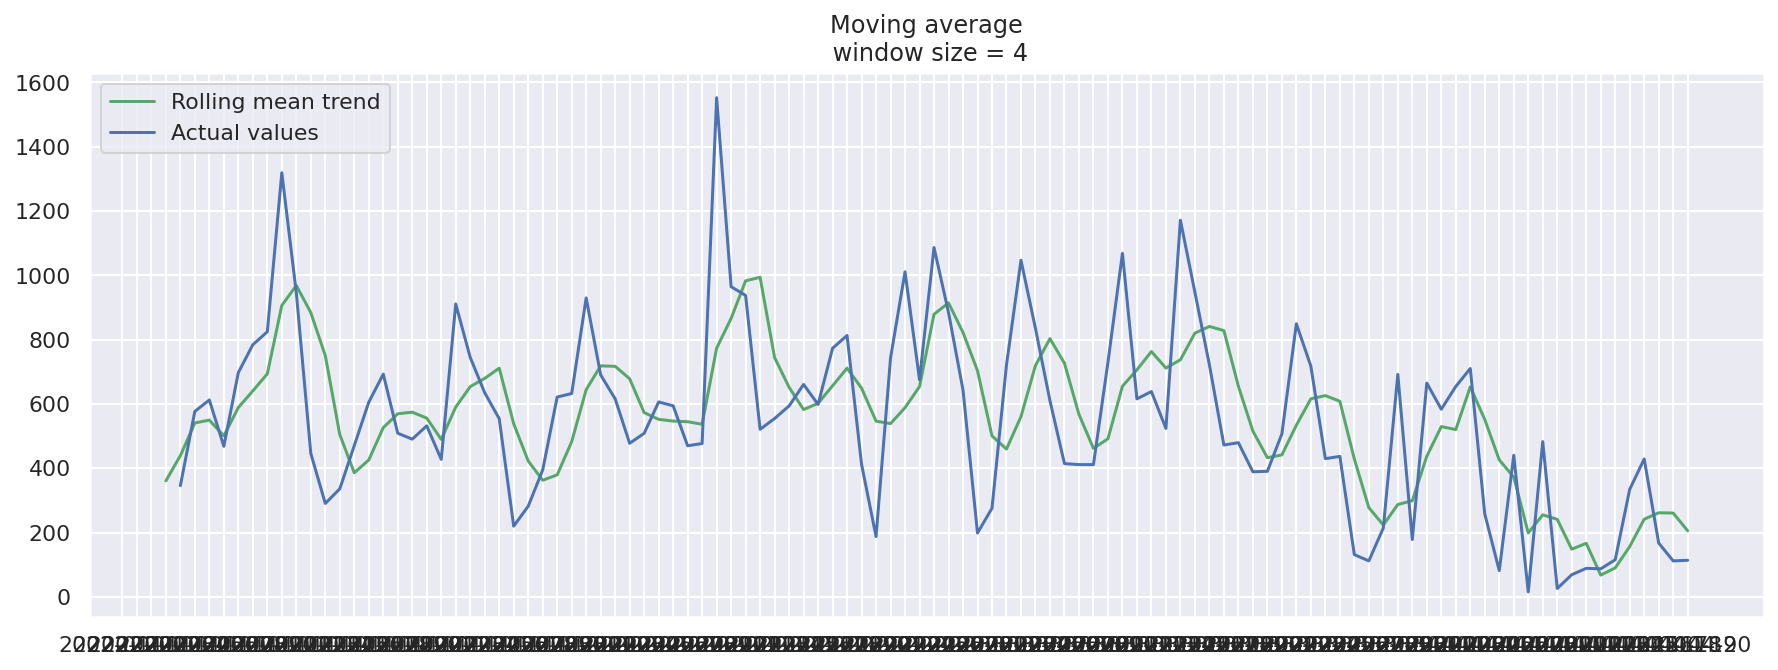

In [29]:
plotMovingAverage(df, 4)

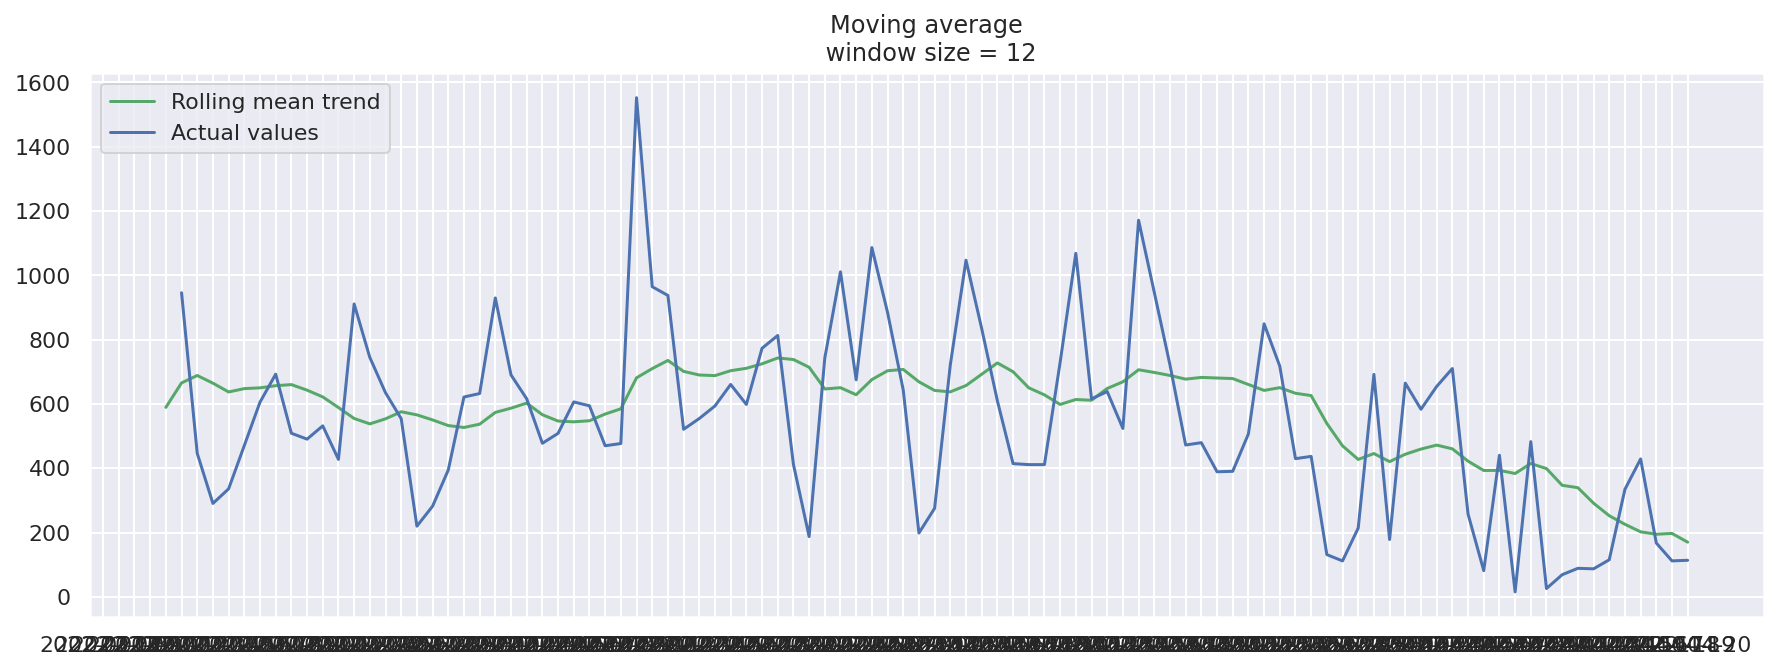

In [30]:
plotMovingAverage(df, 12)

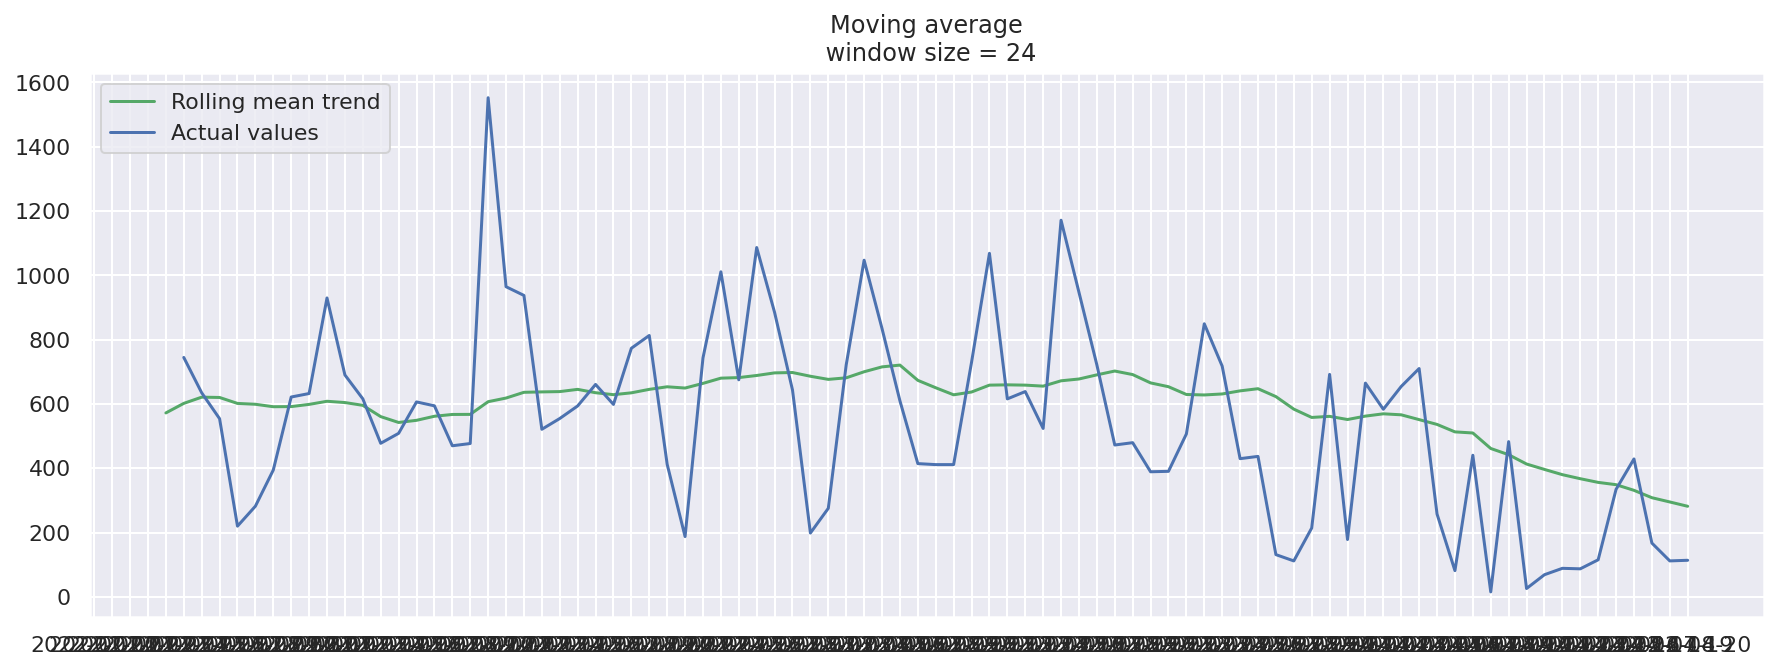

In [31]:
plotMovingAverage(df, 24)

In [32]:
df_anomaly = df.copy()
df_anomaly.iloc[-20] = df_anomaly.iloc[-20] * 0.2  # say we have 80% drop of ads

In [59]:
type(df_anomaly)

pandas.core.series.Series

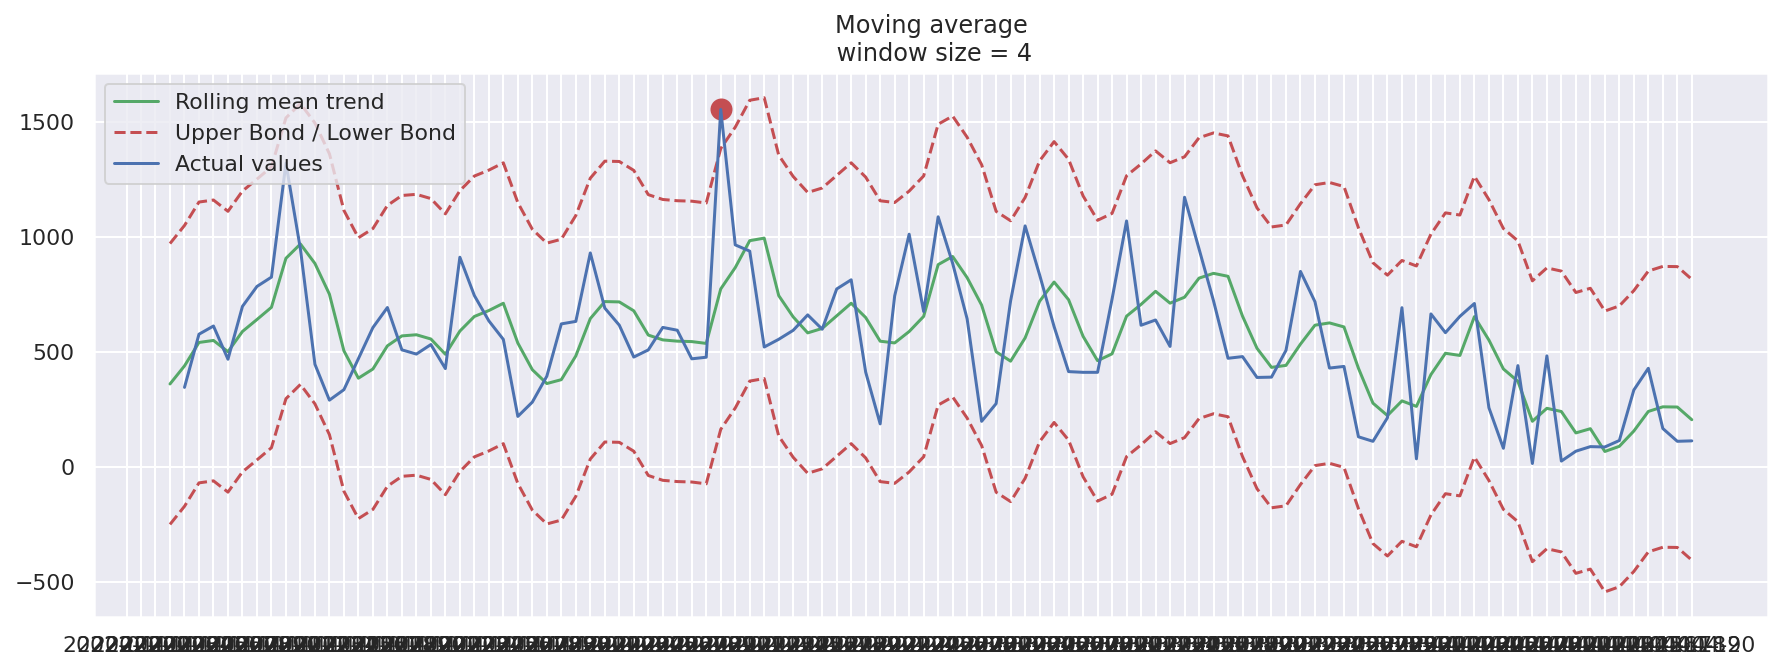

In [64]:
plotMovingAverage(df_anomaly.to_frame(), 4, plot_intervals=True, plot_anomalies=True)

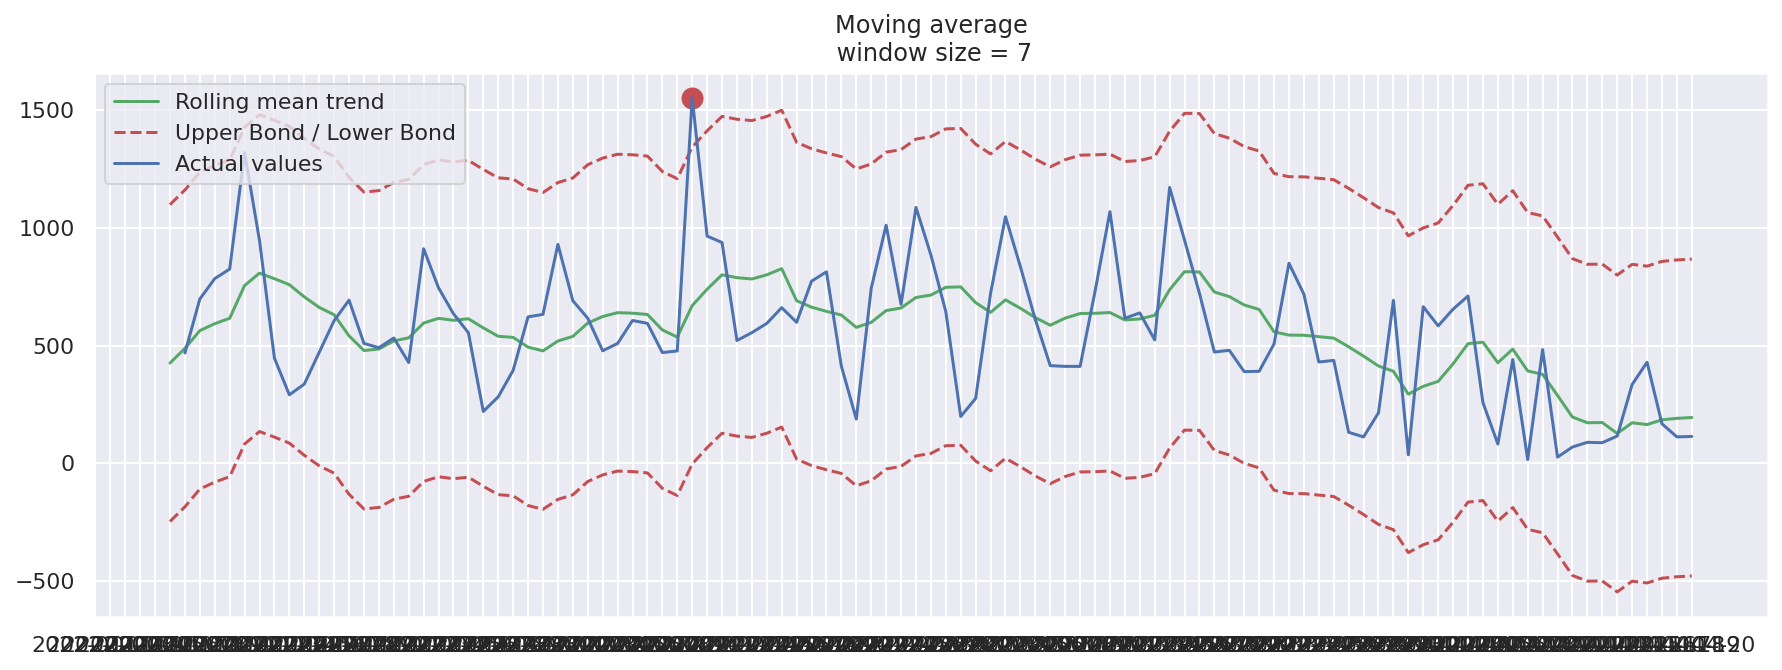

In [65]:
plotMovingAverage(
    df_anomaly.to_frame(), 7, plot_intervals=True, plot_anomalies=True
)  # weekly smoothing

In [66]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n - 1] * weights[n]
    return float(result)

In [67]:
weighted_average(df, [0.6, 0.3, 0.1])

118.5453

In [70]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

In [71]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    with plt.style.context("seaborn-white"):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(
                exponential_smoothing(series, alpha), label="Alpha {}".format(alpha)
            )
        plt.plot(series.values, "c", label="Actual")
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Exponential Smoothing")
        plt.grid(True);

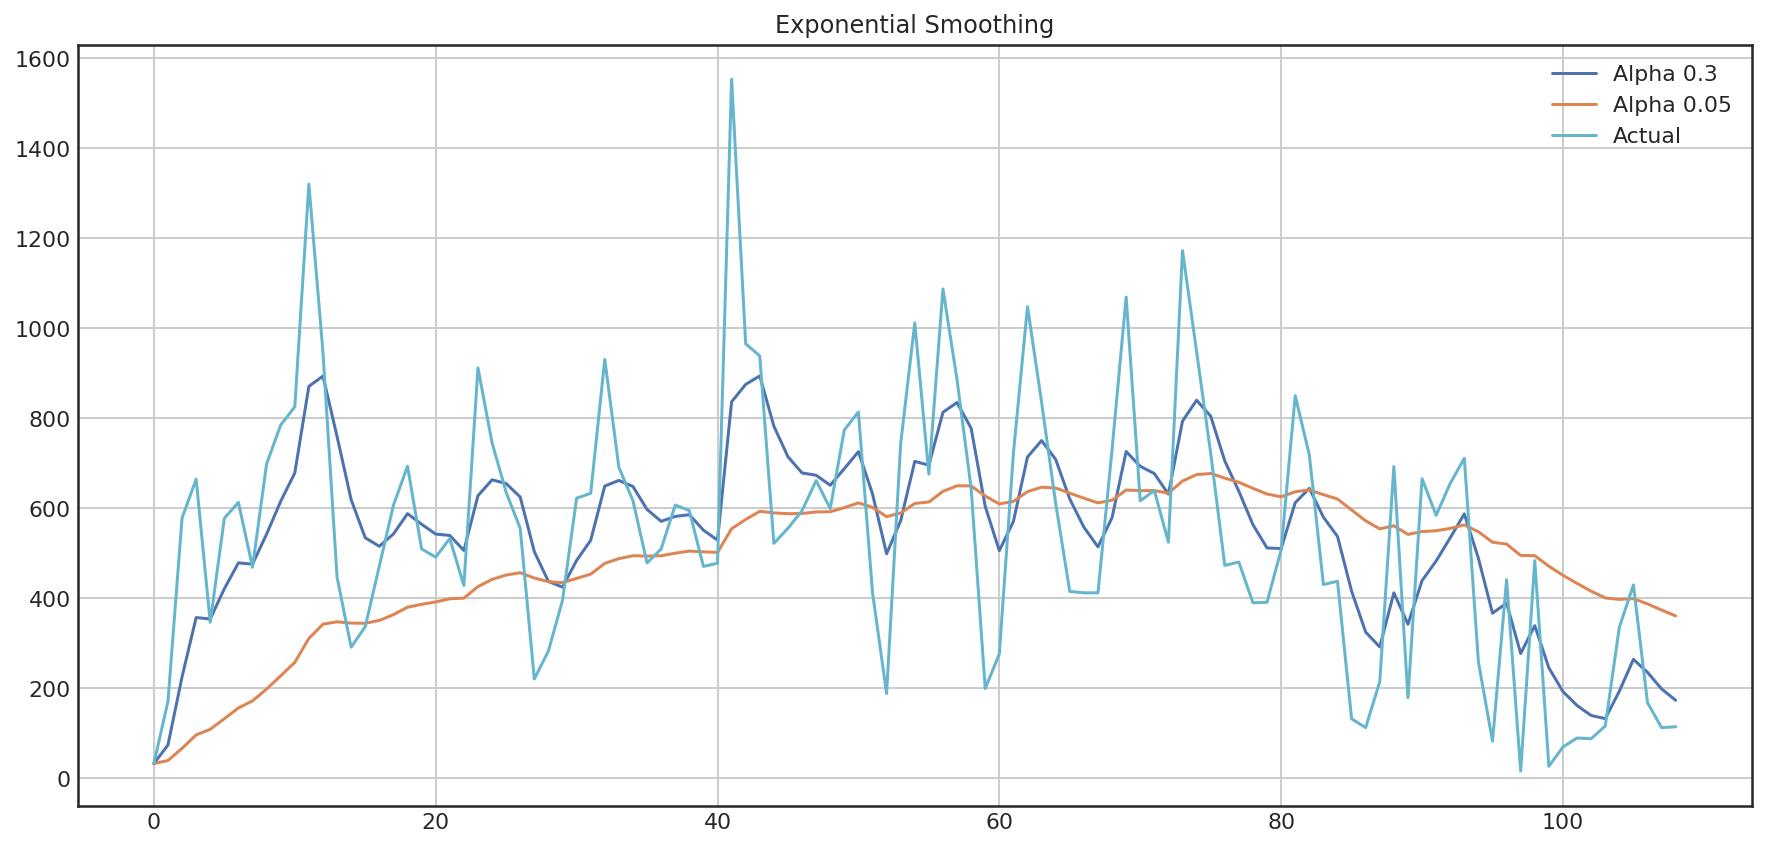

In [73]:
plotExponentialSmoothing(df, [0.3, 0.05])

In [74]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [75]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """

    with plt.style.context("seaborn-white"):
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(
                    double_exponential_smoothing(series, alpha, beta),
                    label="Alpha {}, beta {}".format(alpha, beta),
                )
        plt.plot(series.values, label="Actual")
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

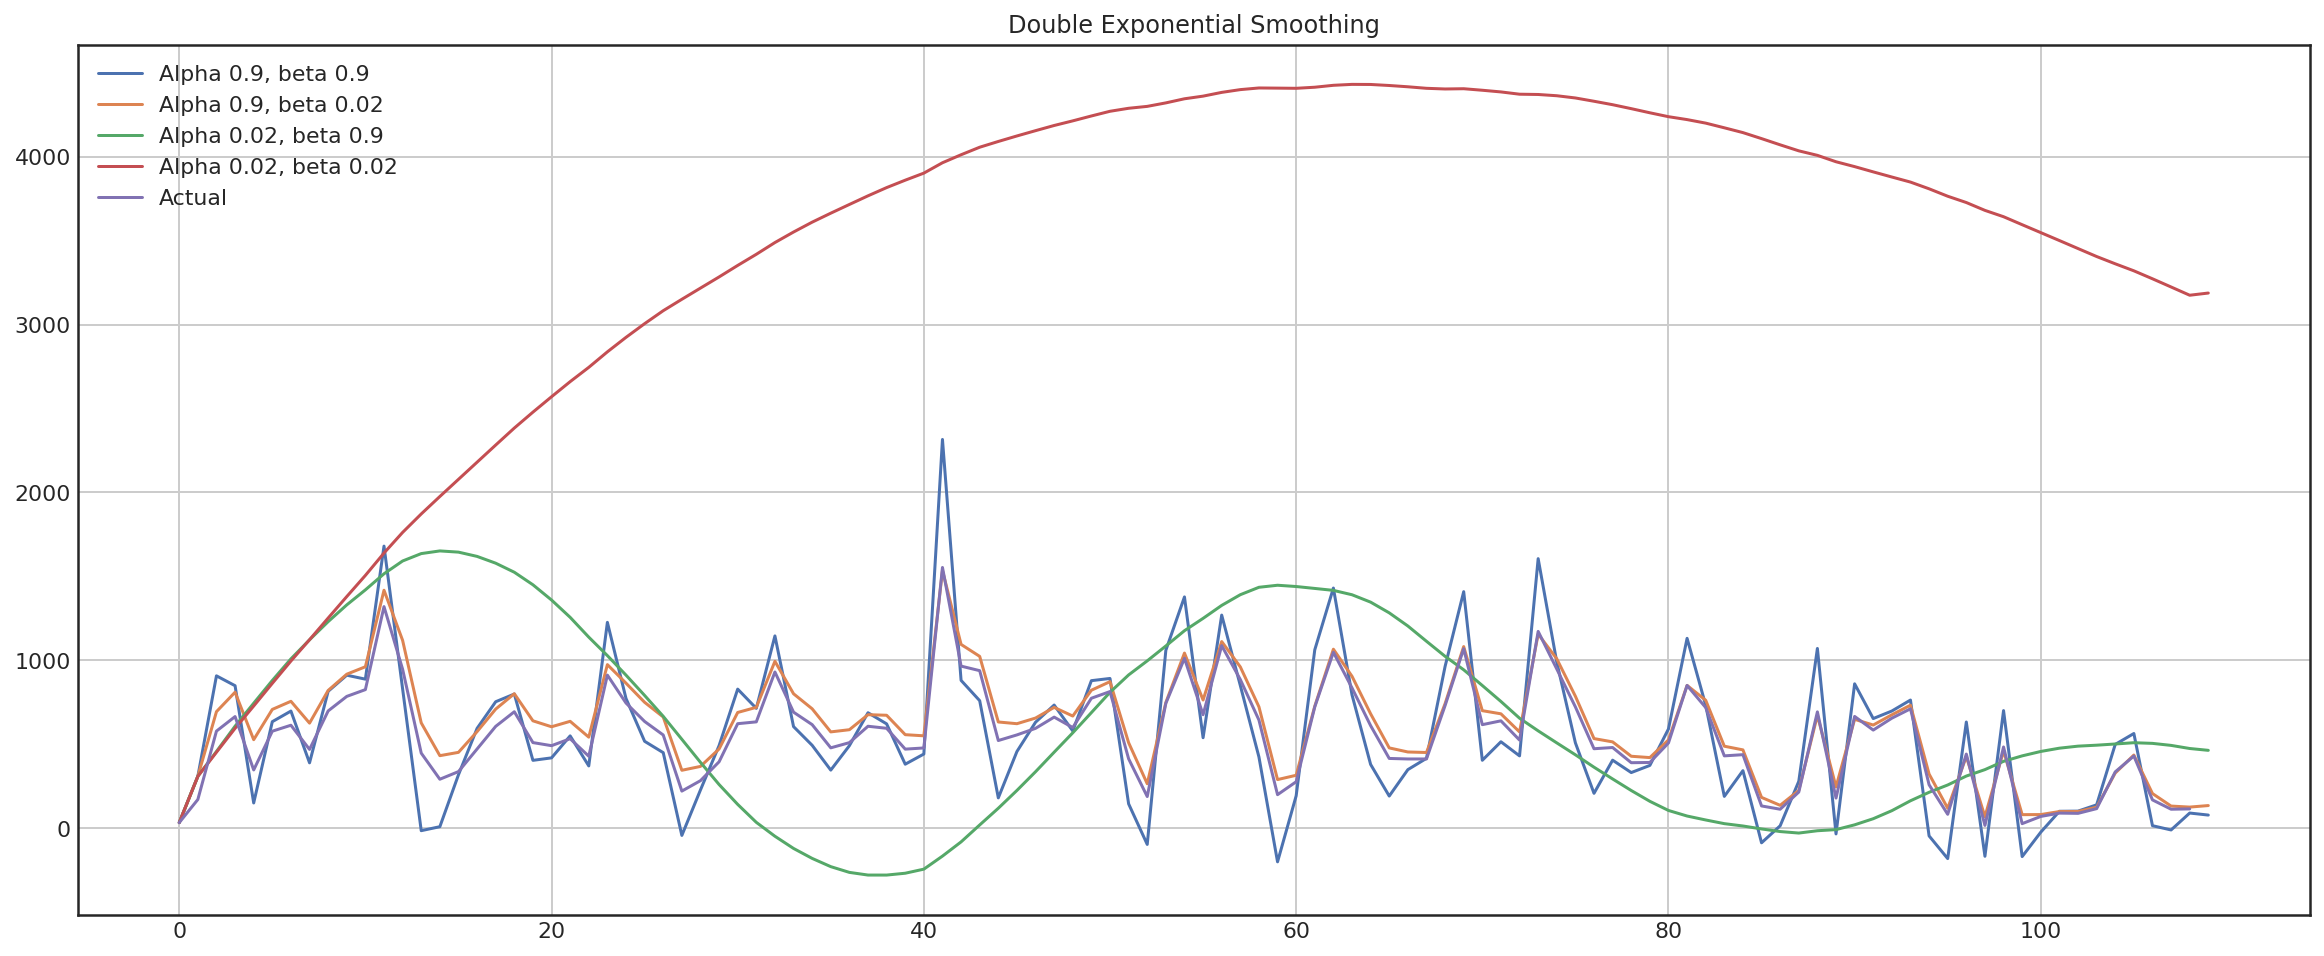

In [76]:
plotDoubleExponentialSmoothing(df, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [77]:
class HoltWinters:

    """
    Holt-Winters model with the anomalies detection using Brutlag method

    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )
                continue

            if i >= len(self.series):  # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [78]:
from sklearn.model_selection import TimeSeriesSplit

In [79]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  

        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=slen,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [81]:
%%time
data = df[:-20]  # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0]

# Minimizing the loss function
opt = minimize(
    timeseriesCVscore,
    x0=x,
    args=(data, mean_squared_log_error),
    method="TNC",
    bounds=((0, 1), (0, 1), (0, 1)),
)

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(
    data,
    slen=24,
    alpha=alpha_final,
    beta=beta_final,
    gamma=gamma_final,
    n_preds=50,
    scaling_factor=3,
)
model.triple_exponential_smoothing()

ZeroDivisionError: float division by zero